In [13]:
import csv
import glob

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from datetime import datetime
from dateutil import parser

np.set_printoptions(suppress=True)

In [14]:
def parse_date(date):
    for DE, EN in translations:
        date = date.replace(DE, EN)
    date = parser.parse(date)
    return date

In [15]:
translations = list()
translations.append(("Mrz", "Mar"))
translations.append(("Mai", "May"))
translations.append(("Okt", "Oct"))
translations.append(("Dez", "Dec"))

# Load

In [16]:
data = dict()
for filename in glob.glob("data/weight_*.csv"):
    with open(filename, newline='\n') as f:

        reader = csv.reader(f, delimiter=',')
        header = next(reader)

        in_date = False

        for i, row in enumerate(reader):

            row = row[:-1]

            if len(row) == 1 and in_date == True:
                in_date = False
                date = line[0]
                date = parse_date(date)
                data[date] = line[1:]
                line = row
            elif len(row) == 1 and in_date == False:
                line = row
                in_date = True
            else:
                in_date = True
                line = [*line, row]
    date = line[0]
    date = parse_date(date)
    data[date] = line[1:]

# Clean

In [17]:
for date, entries in data.items():
    valid_entries = []
    for entry in entries:
        valid_entry = []
        for i, field in enumerate(entry):
            if field == "--":
                field = None
                valid_entry.append(field)
                continue

            if field == "0.0 kg":
                valid_entry.append(field.replace(" kg", ""))
                continue

            if field == "0.0 %":
                valid_entry.append(field.replace(" %", ""))
                continue

            if i in [1, 2, 5, 6]:
                field = field.replace(" kg", "")
                field = float(field)

            if i in [3, 4, 7]:
                field = field.replace(" %", "")
                field = float(field)

            valid_entry.append(field)
        valid_entries.append(valid_entry)
    data[date] = valid_entries

# pandas.DataFrame

In [18]:
df = dict()
df["timestamp"] = []
df["weight"] = []
df["weight_delta"] = []
df["bmi"] = []
df["fat_kg"] = []
df["fat_%"] = []
df["muscle_kg"] = []
df["muscle_%"] = []
df["water_kg"] = []
df["water_%"] = []
df["bone_kg"] = []
df["bone_%"] = []

for date, entries in data.items():
    for entry in entries:
        if len(entry) == 3:
            daytime, weight, bmi = entry
        elif len(entry) == 4:
            daytime, weight, weight_delta, bmi = entry
        elif len(entry) == 7:
            daytime, weight, bmi, fat_percentage, muscle_mass, bone_mass, water_percentage = entry
        else:
            daytime, weight, weight_delta, bmi, fat_percentage, muscle_mass, bone_mass, water_percentage = entry

        if weight_delta is None:
            weight_delta = None

        if fat_percentage is None:
            fat_weight = None
        else:
            fat_weight = (weight * fat_percentage) / 100

        if water_percentage is None:
            water_weight = None
        else:
            water_weight = (weight * water_percentage) / 100

        if muscle_mass is None:
            muscle_percentage = None
        else:
            muscle_percentage = (muscle_mass / weight) * 100

        if bone_mass is None:
            bone_percentage = None
        else:
            bone_percentage = (bone_mass / weight) * 100

        date = date.replace(hour=int(daytime[:2]), minute=int(daytime[3:]))

        df["timestamp"].append(date)
        df["weight"].append(weight)
        df["weight_delta"].append(weight_delta)
        df["bmi"].append(bmi)
        df["fat_kg"].append(fat_weight)
        df["fat_%"].append(fat_percentage)
        df["muscle_%"].append(muscle_percentage)
        df["muscle_kg"].append(muscle_mass)
        df["water_%"].append(water_percentage)
        df["water_kg"].append(water_weight)
        df["bone_%"].append(bone_percentage)
        df["bone_kg"].append(bone_mass)

In [19]:
 def show():
    _, axes = plt.subplots(1, 1, figsize=(20, 5))
    axes.plot(df["timestamp"], df["weight"])
    axes.set_title("Weight in kg.")
    axes.grid(which="major")
    axes.grid(which="minor", linewidth=0.75, linestyle="dotted")
    axes.minorticks_on()
    plt.show()

    _, axes = plt.subplots(1, 1, figsize=(20, 5))
    axes.plot(df["timestamp"], df["fat_kg"])
    axes.set_title("Fat in kg.")
    axes.grid(which="major")
    axes.grid(which="minor", linewidth=0.75, linestyle="dotted")
    axes.minorticks_on()
    plt.show()

    _, axes = plt.subplots(1, 1, figsize=(20, 5))
    axes.plot(df["timestamp"], df["muscle_kg"])
    axes.set_title("Muscle in kg.")
    axes.grid(which="major")
    axes.grid(which="minor", linewidth=0.75, linestyle="dotted")
    axes.minorticks_on()
    plt.show()

In [20]:
df = pd.DataFrame(df)
df = df.sort_values(by="timestamp")
df.tail(25)[::-1]

,timestamp,weight,weight_delta,bmi,fat_kg,fat_%,muscle_kg,muscle_%,water_kg,water_%,bone_kg,bone_%
179,2024-07-03 06:22:00,89.7,1.3,26.5,20.9001,23.3,36.2,40.356745,50.2320,56.0,5.8,6.465998
180,2024-07-02 18:57:00,91.0,0.3,26.9,21.7490,23.9,36.5,40.109890,50.5960,55.6,5.8,6.373626
181,2024-07-02 07:40:00,90.7,0.3,26.8,20.9517,23.1,36.5,40.242558,50.8827,56.1,5.9,6.504961
182,2024-07-02 07:30:00,91.0,0.3,26.9,21.6580,23.8,36.5,40.109890,50.5960,55.6,5.8,6.373626
183,2024-07-01 07:35:00,91.3,0.6,27.0,22.0946,24.2,36.6,40.087623,50.4889,55.3,5.8,6.352683
184,2024-06-30 11:44:00,90.7,0.7,26.8,21.3145,23.5,36.5,40.242558,50.7013,55.9,5.9,6.504961
185,2024-06-29 06:19:00,91.4,1.0,27.0,21.3876,23.4,36.6,40.043764,51.0926,55.9,5.9,6.455142
186,2024-06-28 07:22:00,90.4,0.2,26.7,21.7864,24.1,36.4,40.265487,50.0816,55.4,5.8,6.415929
187,2024-06-27 07:51:00,90.2,0.0,26.6,21.2872,23.6,36.3,40.243902,50.3316,55.8,5.8,6.430155
188,2024-06-26 07:14:00,90.6,1.4,26.7,21.5628,23.8,36.4,40.176600,50.3736,55.6,5.8,6.401766


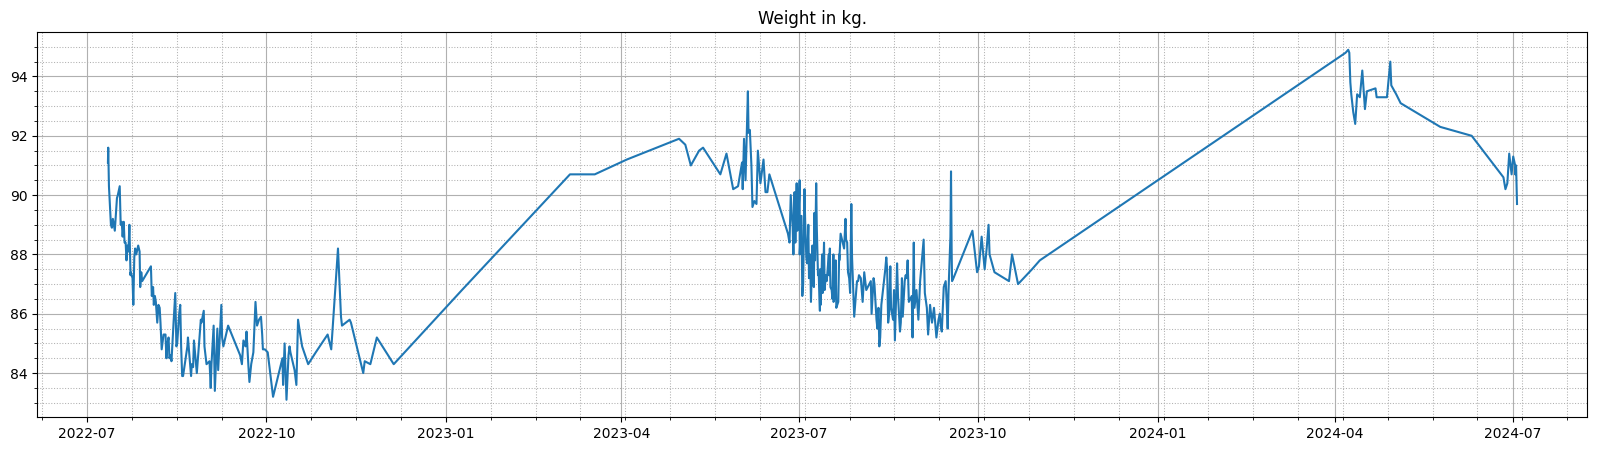

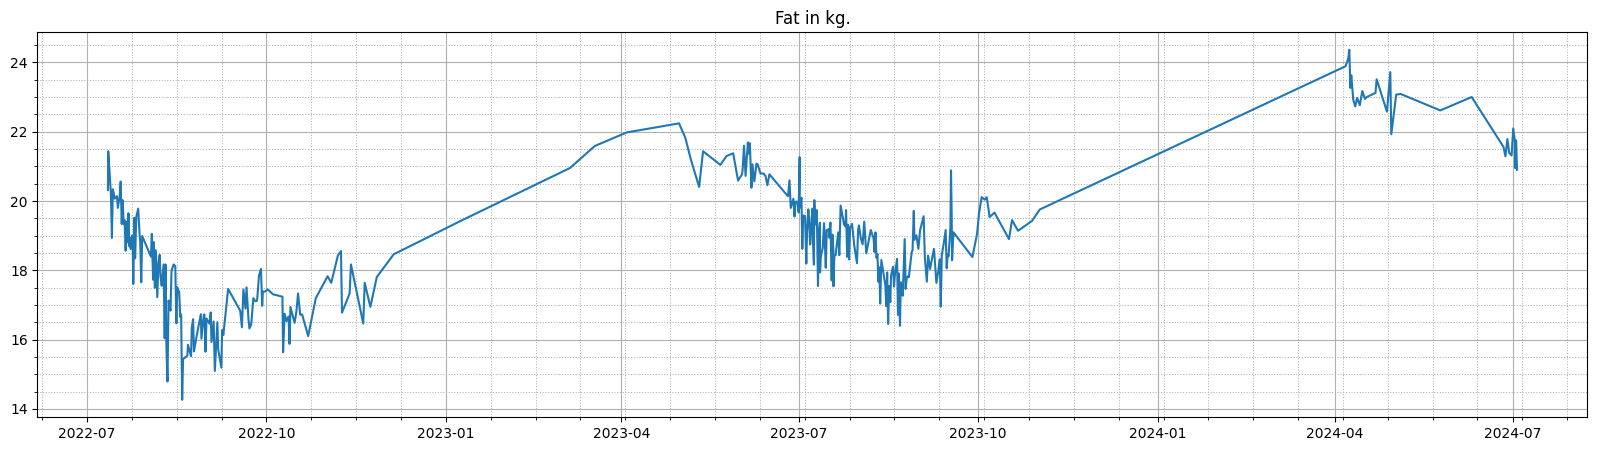

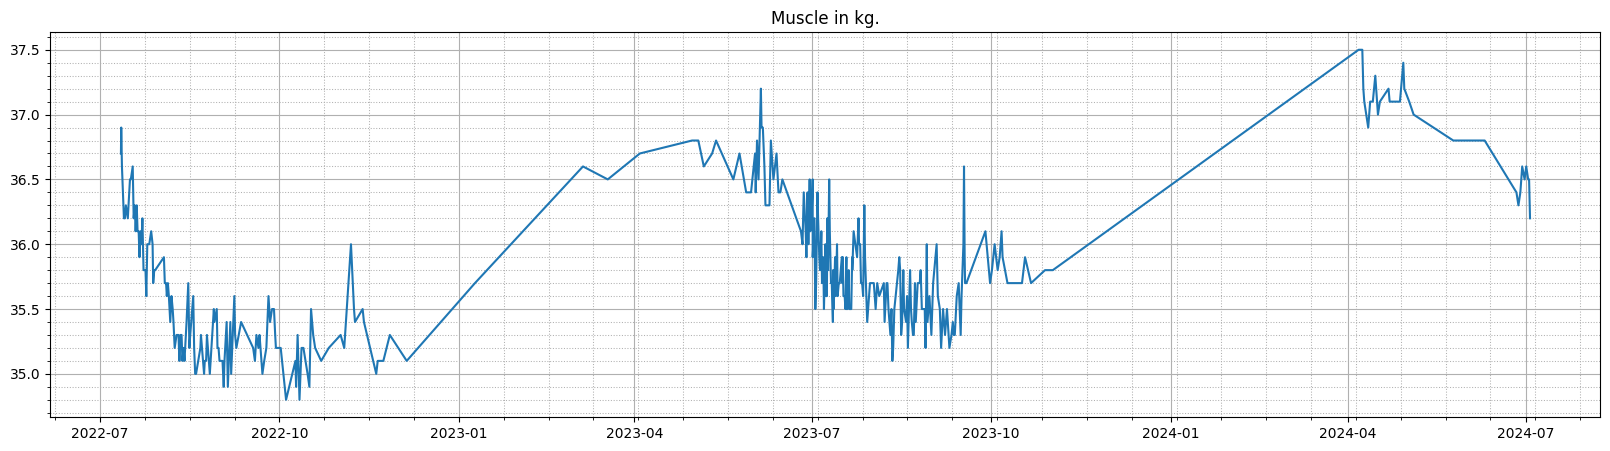

In [21]:
show()

In [22]:
selection = df.dropna()[["timestamp", "fat_kg", "muscle_kg", "water_kg", "bone_kg"]]

for key in ["fat", "muscle", "water", "bone"]:
    selection[f"{key}_delta_kg"] = [0.0,
                                    *(np.array(selection[f"{key}_kg"][1:]) - np.array(selection[f"{key}_kg"][:-1]))]

selection["delta_kg"] = selection["fat_delta_kg"] + selection["muscle_delta_kg"] + selection["water_delta_kg"] + \
                        selection["bone_delta_kg"]
delta_kg = np.abs(selection["fat_delta_kg"]) + np.abs(selection["muscle_delta_kg"]) + np.abs(
    selection["water_delta_kg"]) + np.abs(selection["bone_delta_kg"])

for key in ["fat", "muscle", "water", "bone"]:
    selection[f"{key}_%"] = (selection[f"{key}_delta_kg"] / delta_kg) * 100

keys = ["timestamp",
        "delta_kg",
        "fat_kg", "fat_delta_kg", "fat_%",
        "muscle_kg", "muscle_delta_kg", "muscle_%",
        "water_kg", "water_delta_kg", "water_%",
        "bone_delta_kg", "bone_%"
        ]
selection = selection[keys]
selection = selection.sort_values(by="timestamp")
selection.tail(25)[::-1]

,timestamp,delta_kg,fat_kg,fat_delta_kg,fat_%,muscle_kg,muscle_delta_kg,muscle_%,water_kg,water_delta_kg,water_%,bone_delta_kg,bone_%
179,2024-07-03 06:22:00,-1.5129,20.9001,-0.8489,-56.110781,36.2,-0.3,-19.829467,50.2320,-0.3640,-24.059753,0.0,0.000000
180,2024-07-02 18:57:00,0.4106,21.7490,0.7973,67.339527,36.5,0.0,0.000000,50.5960,-0.2867,-24.214527,-0.1,-8.445946
181,2024-07-02 07:40:00,-0.3196,20.9517,-0.7063,-64.620311,36.5,0.0,0.000000,50.8827,0.2867,26.230558,0.1,9.149131
182,2024-07-02 07:30:00,-0.4295,21.6580,-0.4366,-67.826627,36.5,-0.1,-15.535187,50.5960,0.1071,16.638185,0.0,0.000000
183,2024-07-01 07:35:00,0.5677,22.0946,0.7801,65.417191,36.6,0.1,8.385744,50.4889,-0.2124,-17.811321,-0.1,-8.385744
184,2024-06-30 11:44:00,-0.5644,21.3145,-0.0731,-12.951807,36.5,-0.1,-17.717931,50.7013,-0.3913,-69.330262,0.0,0.000000
185,2024-06-29 06:19:00,0.9122,21.3876,-0.3988,-23.324365,36.6,0.2,11.697275,51.0926,1.0110,59.129723,0.1,5.848637
186,2024-06-28 07:22:00,0.3492,21.7864,0.4992,58.784739,36.4,0.1,11.775789,50.0816,-0.2500,-29.439472,0.0,0.000000
187,2024-06-27 07:51:00,-0.4176,21.2872,-0.2756,-65.996169,36.3,-0.1,-23.946360,50.3316,-0.0420,-10.057471,0.0,0.000000
188,2024-06-26 07:14:00,-1.7876,21.5628,-1.4372,-76.171295,36.4,-0.4,-21.199915,50.3736,0.0496,2.628789,0.0,0.000000


[19900.  19900.5 19901.  19901.5 19902.  19902.5 19903.  19903.5 19904.
 19904.5 19905.  19905.5 19906.  19906.5 19907.  19907.5 19908.  19908.5]


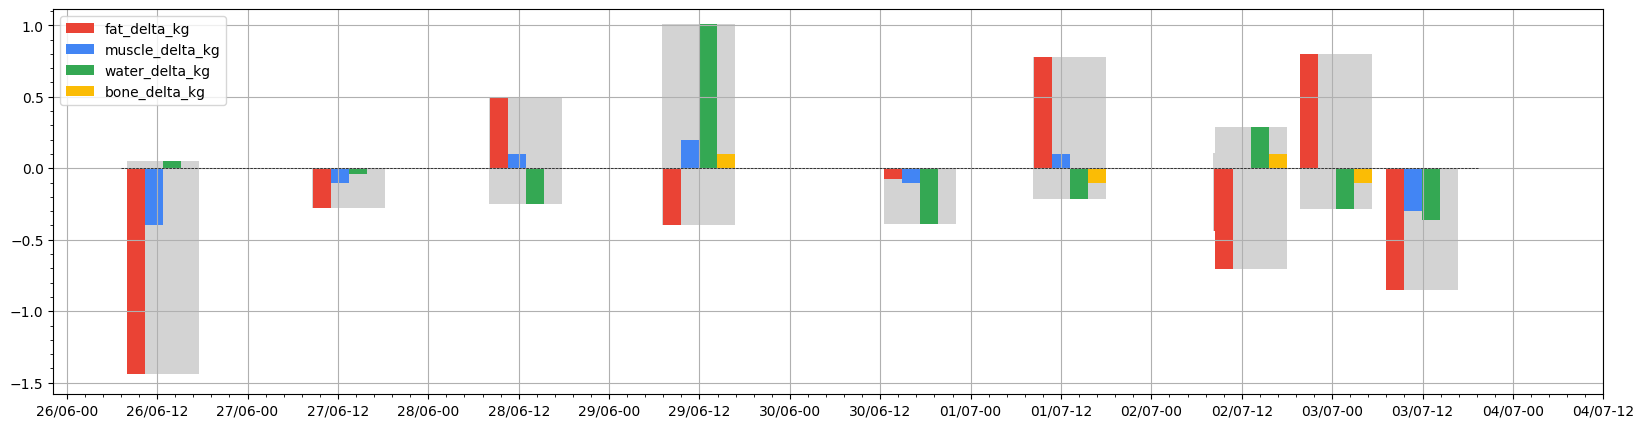

In [23]:
idx = 10
fat_delta_kg = np.asarray(selection["fat_delta_kg"].iloc[-idx:])
muscle_delta_kg = np.asarray(selection["muscle_delta_kg"].iloc[-idx:])
water_delta_kg = np.asarray(selection["water_delta_kg"].iloc[-idx:])
bone_delta_kg = np.asarray(selection["bone_delta_kg"].iloc[-idx:])
keys = selection["timestamp"].iloc[-idx:]

colors = ["#EA4335", "#4285F4", "#34A853", "#FBBC05"]
labels = ["fat_delta_kg", "muscle_delta_kg", "water_delta_kg", "bone_delta_kg"]

start = keys.iloc[0]
start = start.replace(hour=0, minute=0, second=0)
start = start.timestamp()

end = keys.iloc[-1]
end = end.replace(day=end.day + 1, hour=0, minute=0, second=0)
end = end.timestamp()

steps = np.arange(start, end, 24 * 60 * 60)
steps = [datetime.fromtimestamp(step) for step in steps]

ymin, ymax = np.inf, -np.inf
fig, axes = plt.subplots(1, 1, figsize=(20, 5))
for i in range(idx):
    
    vs = np.array([fat_delta_kg[i], muscle_delta_kg[i], water_delta_kg[i], bone_delta_kg[i]])
    
    ymin = min(np.min(vs), ymin)
    ymax = max(np.max(vs), ymax)
    
    multiplier = 0
    width = 0.1
    
    offset = 12750
    axes.bar(datetime.fromtimestamp(keys.iloc[i].timestamp() + offset), height=np.abs(np.min(vs)) + np.max(vs), width=width * 4, bottom=np.min(vs), color="lightgray")
    
    for j, v in enumerate(vs):
        offset = width * multiplier
        if i == 0:
            axes.bar(datetime.fromtimestamp(keys.iloc[i].timestamp() + offset), v, width, color=colors[j], label=labels[j])
        else:
            axes.bar(datetime.fromtimestamp(keys.iloc[i].timestamp() + offset), v, width, color=colors[j])
        multiplier += 86000

steps = np.arange(np.floor(axes.get_xticks()[0]), np.ceil(axes.get_xticks()[-1]) + 1, 0.5)
print(steps)

from matplotlib.dates import DateFormatter
myFmt = DateFormatter("%d/%m-%H")
axes.xaxis.set_major_formatter(myFmt)

axes.hlines([0.0], xmin=keys.iloc[0], xmax=datetime.fromtimestamp(keys.iloc[-1].timestamp() + offset + 60 * 60 * 4), linestyle="dashed", color="black", linewidth=0.5)
axes.set_xticks(steps)
axes.legend(loc="upper left")
axes.set_ylim(ymin * 1.1, ymax * 1.1)
axes.grid(which="major")
#axes.grid(which="minor", linewidth=0.75, linestyle="dotted")
axes.minorticks_on()
plt.show()